In [1]:
import os
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import sys
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Add necessary paths for custom modules
sys.path.append("/share/u/wendler/code/my-sdxl-unbox")

from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area_turbo

import supervision as sv
import pycocotools.mask as mask_util
from torchvision.ops import box_convert

# Grounded SAM2 and Grounding DINO imports
sys.path.append("/share/u/wendler/code/Grounded-SAM-2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, predict
import grounding_dino.groundingdino.datasets.transforms as T


In [2]:

n_steps = 4
m1 = 4.
k_transfer = 32
use_down = True
use_up = True
use_up0 = True
use_mid = True
prefix = '../results/PIE-Bench-debug'
dtype = "float32"

In [3]:
code_to_block = {
        "down.2.1": "unet.down_blocks.2.attentions.1",
        "up.0.1": "unet.up_blocks.0.attentions.1",
        "up.0.0": "unet.up_blocks.0.attentions.0",
        "mid.0": "unet.mid_block.attentions.0",
    }

In [4]:
# Add SDLens/src to sys.path at the top of the scrip

# --- Utility functions ---
def resize_mask(mask, size=(16, 16)):
    # consider all 32 by 32 windows in the mask
    small = cv2.resize(mask.astype(np.float32), size, interpolation=cv2.INTER_LANCZOS4) > 0
    if small.astype(np.float32).sum() == 0:
        tmp = mask.reshape(16, 32, 16, 32).astype(np.float32)
        tmp = tmp.sum(axis=1)
        tmp = tmp.sum(axis=2)
        if (tmp >= 32*32).astype(np.float32).sum() == 0:
            print("trying to fix the mask...")
            # set the maximum gridcell to 1
            amax = tmp.argmax()
            tmp[np.unravel_index(amax, tmp.shape)] = 1
            return tmp.astype(bool)
    return small

from matplotlib import pyplot as plt
from typing import Tuple
import grounding_dino.groundingdino.datasets.transforms as T

def sam_mask(img, prompt, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD):
    def load_image(img) -> Tuple[np.array, torch.Tensor]:
        transform = T.Compose(
            [
                T.RandomResize([800], max_size=1333),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        image_source = img.convert("RGB")
        image = np.asarray(image_source)
        image_transformed, _ = transform(image_source, None)
        return image, image_transformed
    image_source, image = load_image(img)
    sam2_predictor.set_image(image_source)

    boxes, confidences, labels = predict(
        model=grounding_model,
        image=image,
        caption=prompt,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
    )

    # process the box prompt for SAM 2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


    # FIXME: figure how does this influence the G-DINO model
    # torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    #if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        #torch.backends.cuda.matmul.allow_tf32 = True
        #torch.backends.cudnn.allow_tf32 = True

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    """
    Post-process the output of the model to get the masks, scores, and logits for visualization
    """
    # convert the shape to (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)


    confidences = confidences.numpy().tolist()
    class_names = labels

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(class_names, confidences)
    ]

    detections = sv.Detections(
        xyxy=input_boxes,  # (n, 4)
        mask=masks.astype(bool),  # (n, h, w)
        class_id=class_ids
    )

    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    label_annotator = sv.LabelAnnotator()
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    mask_annotator = sv.MaskAnnotator()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    return detections, labels, annotated_frame
    

def best_features_saeuron(source_feats, target_feats, k=10):
    mean_source = source_feats.mean(dim=0).mean(dim=0)
    mean_target = target_feats.mean(dim=0).mean(dim=0)
    scores = mean_source/mean_source.sum() - mean_target/mean_target.sum()
    arg_sorted = np.argsort(scores.cpu().detach().numpy())
    return arg_sorted[::-1][:k].copy(), arg_sorted[:k].copy()

def best_features_neuron(source_feats, target_feats, k=10):
    mean_source = source_feats.mean(dim=0).mean(dim=0)
    mean_target = target_feats.mean(dim=0).mean(dim=0)
    scores = (mean_source/mean_source.sum() - mean_target/mean_target.sum()).abs()
    arg_sorted = np.argsort(scores.cpu().detach().numpy())
    return arg_sorted[::-1][:k].copy(), arg_sorted[:k].copy()

@torch.no_grad()
def get_features_per_block(cache1, cache2, mask1, mask2, k_transfer=None, blocks_to_intervene=None, saes=None):
    print(blocks_to_intervene)
    to_source_features_dict = {}
    to_target_features_dict = {}
    source_feats_dict = {}
    target_feats_dict = {}
    source_dict = {}
    target_dict = {}
    for shortcut in blocks_to_intervene:
        block = code_to_block[shortcut]
        diff1 = cache1['output'][block][0] - cache1['input'][block][0]
        diff2 = cache2['output'][block][0] - cache2['input'][block][0]
        source = diff1[:, :, mask1]
        target = diff2[:, :, mask2]
        sae = saes[shortcut]
        source_feats = sae.encode(source.permute(0, 2, 1))
        target_feats = sae.encode(target.permute(0, 2, 1))
        to_source_features, to_target_features = best_features_saeuron(source_feats, target_feats, k=k_transfer)
        to_source_features_dict[shortcut] = to_source_features
        to_target_features_dict[shortcut] = to_target_features
        source_feats_dict[shortcut] = source_feats.detach().cpu()
        target_feats_dict[shortcut] = target_feats.detach().cpu()
        source_dict[shortcut] = source.detach().cpu()
        target_dict[shortcut] = target.detach().cpu()   
    return to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict
    
@torch.no_grad()
def get_features_all_blocks(cache1, cache2, mask1, mask2, k_transfer=None, blocks_to_intervene=None, saes=None,
                            normalize=False):
    source_feats_all = []
    target_feats_all = []
    to_source_feats_dict = {}
    to_target_feats_dict = {}
    source_feats_dict = {}
    target_feats_dict = {}
    source_dict = {}
    target_dict = {}
    block_sizes = {}
    for shortcut in blocks_to_intervene:
        block = code_to_block[shortcut]
        diff1 = cache1['output'][block][0] - cache1['input'][block][0]
        diff2 = cache2['output'][block][0] - cache2['input'][block][0]
        source = diff1[:, :, mask1]
        target = diff2[:, :, mask2]
        sae = saes[shortcut]
        source_feats = sae.encode(source.permute(0, 2, 1))
        target_feats = sae.encode(target.permute(0, 2, 1))
        if normalize:
            source_feats_all.append(source_feats/source_feats.mean(dim=1, keepdim=True).norm(dim=-1, keepdim=True))
            target_feats_all.append(target_feats/target_feats.mean(dim=1, keepdim=True).norm(dim=-1, keepdim=True))
        else:
            source_feats_all.append(source_feats)
            target_feats_all.append(target_feats)
        source_dict[shortcut] = source.detach().cpu()
        target_dict[shortcut] = target.detach().cpu()
        source_feats_dict[shortcut] = source_feats.detach().cpu() 
        target_feats_dict[shortcut] = target_feats.detach().cpu()
        block_sizes[shortcut] = source_feats.shape[-1]
    source_feats_all = torch.cat(source_feats_all, dim=-1)
    target_feats_all = torch.cat(target_feats_all, dim=-1)
    to_source_feats_all, to_target_feats_all = best_features_saeuron(source_feats_all, target_feats_all, k=k_transfer)
    start = 0
    for idx, shortcut in enumerate(blocks_to_intervene):
        to_source_feats = []
        to_target_feats = []
        for feat in to_source_feats_all:
            if feat >= start and feat < start+block_sizes[shortcut]:
                to_source_feats.append(feat-start)
        for feat in to_target_feats_all:
            if feat >= start and feat < start + block_sizes[shortcut]:
                to_target_feats.append(feat-start)
        to_source_feats_dict[shortcut] = np.asarray(to_source_feats)
        to_target_feats_dict[shortcut] = np.asarray(to_target_feats)
        start += block_sizes[shortcut]

    return to_source_feats_dict, to_target_feats_dict, source_feats_dict, target_feats_dict, source_dict, target_dict

def get_neuron_layer_name(block, lidx):
    return code_to_block[block] + f'.transformer_blocks.{lidx}.ff.net.0'

@torch.no_grad()
def get_neurons_all_blocks(cache1, cache2, mask1, mask2, k_transfer=None, blocks_to_intervene=None, saes=None,
                            normalize=True):
    to_source_neurons_dict = {}
    to_target_neurons_dict = {}
    source_dict = {}
    target_dict = {}
    block_sizes = {}
    neurons1_all = []
    neurons2_all = []
    for shortcut in blocks_to_intervene:
        block = code_to_block[shortcut]
        for lidx in range(10):
            layer = get_neuron_layer_name(shortcut, lidx)
            neurons1 = cache1['output'][layer][0]
            neurons2 = cache2['output'][layer][0]
            neurons1 = neurons1[:, mask1.flatten(), :]
            neurons2 = neurons2[:, mask2.flatten(), :]
            if normalize:
                neurons1_all.append(neurons1/neurons1.norm(dim=1, keepdim=True))
                neurons2_all.append(neurons2/neurons2.norm(dim=1, keepdim=True))
            else:
                neurons1_all.append(neurons1)
                neurons2_all.append(neurons2)
            source_dict[layer] = neurons1.detach().cpu()
            target_dict[layer] = neurons2.detach().cpu()
            block_sizes[layer] = neurons1.shape[-1]
    neurons1_all = torch.cat(neurons1_all, dim=-1)
    neurons2_all = torch.cat(neurons2_all, dim=-1)
    to_source_neurons_all, to_target_neurons_all = best_features_saeuron(neurons1_all, neurons2_all, k=k_transfer)
    start = 0
    for idx, shortcut in enumerate(blocks_to_intervene):
        for lidx in range(10):
            layer = get_neuron_layer_name(shortcut, lidx)
            to_source_neurons = []
            to_target_neurons = []
            for nidx in to_source_neurons_all:
                if nidx >= start and nidx < start+block_sizes[layer]:
                    to_source_neurons.append(nidx-start)
            for nidx in to_target_neurons_all:
                if nidx >= start and nidx < start+block_sizes[layer]:
                    to_target_neurons.append(nidx-start)
            to_source_neurons_dict[layer] = np.asarray(to_source_neurons)
            to_target_neurons_dict[layer] = np.asarray(to_target_neurons)
            start += block_sizes[layer]
    return to_source_neurons_dict, to_target_neurons_dict, source_dict, target_dict

In [5]:
if dtype == "float16":
    dtype = torch.float16
else:
    dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    'stabilityai/sdxl-turbo',
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)
if dtype == torch.float32:
    pipe.text_encoder_2.to(dtype=dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
SAM2_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "/share/u/wendler/code/Grounded-SAM-2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=device
)

path_to_checkpoints = '/share/u/wendler/code/my-sdxl-unbox/checkpoints/'
blocks = list(code_to_block.values())
saes = {}
k = 10
exp = 4
for shortcut in code_to_block.keys():
    block = code_to_block[shortcut]
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{exp*1280:d}_auxk256_bs4096_lr0.0001", "final")
    ).to(device, dtype=dtype)
    saes[shortcut] = sae

final text_encoder_type: bert-base-uncased


In [7]:
from functools import partial
import json
# --- Main experiment ---
def add_featuremaps_and_eps(sae, to_source_features, to_target_features, m1, fmaps, target_mask, module, input, output, eps_source=None):
    diff = output[0] - input[0]
    coefs = sae.encode(diff.permute(0, 2, 3, 1))
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    # norm adjustment not needed because the columns have norm 1 already!
    norm_source = sae.decoder.weight[:, to_source_features].norm(dim=0).sum(dim=0)
    norm_target = sae.decoder.weight[:, to_target_features].norm(dim=0).sum(dim=0)
    if norm_target > 0:
        normadjustment = (norm_source/norm_target)
    else:
        normadjustment = 0
    #print(normadjustment)
    mask[0,target_mask][..., to_target_features] -= normadjustment*m1*coefs[0, target_mask][..., to_target_features]
    mask[..., to_source_features] += fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    print(to_add.shape)
    print(coefs.shape)
    print('diff')
    print(diff.shape)
    print(diff.permute(0, 2, 3, 1).shape)
    eps_target = torch.zeros_like(diff, device=diff.device)
    eps_target[:, :, target_mask] -= diff[:, :, target_mask] - (coefs[:, target_mask] @ sae.decoder.weight.T).permute(0, 2, 1)
    if eps_source is not None:
        return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device) + eps_target + eps_source,)
    else:
        return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device) + eps_target,)

def add_featuremaps(sae, to_source_features, to_target_features, m1, fmaps, target_mask, module, input, output):
    diff = output[0] - input[0]
    coefs = sae.encode(diff.permute(0, 2, 3, 1))
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    # norm adjustment not needed because the columns have norm 1 already!
    norm_source = sae.decoder.weight[:, to_source_features].norm(dim=0).sum(dim=0)
    norm_target = sae.decoder.weight[:, to_target_features].norm(dim=0).sum(dim=0)
    if norm_target > 0:
        normadjustment = (norm_source/norm_target)
    else:
        normadjustment = 0
    #print(normadjustment)
    mask[0,target_mask][..., to_target_features] -= normadjustment*m1*coefs[0, target_mask][..., to_target_features]
    mask[..., to_source_features] += fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

def add_featuremaps_rescaling(sae, to_source_features, fmaps, module, input, output):
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    mask[..., to_source_features] += fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    out = output[0]/output[0].norm(dim=1, keepdim=True)
    out *= output[0].norm(dim=1, keepdim=True)  - to_add.permute(0, 3, 1, 2).norm(dim=1, keepdim=True)
    out += to_add.permute(0, 3, 1, 2).to(output[0].device)
    return (out, )

def ablation(sae, feature_idcs, fmaps, module, input, output):
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    mask[..., feature_idcs] -= fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

def add_activations(delta, module, input, output):
    if isinstance(output, torch.Tensor):
        return output + delta
    else:  
        return (output[0] + delta,)

def main(prompt1, prompt2, gsam_prompt1, gsam_prompt2, pipe=pipe, k=10, 
         blocks_to_intervene=["down.2.1", "up.0.1", "up.0.0", "mid.0"],
         n_steps=1, m1=1., k_transfer=10, stat="quantile", mode="sae_1",  
         combine_blocks=True, use_source_mask_in_both=False, subtract_target_add_source=False,
         maintain_spatial_info=False, verbose=False,
         sam_predictor=sam2_predictor, grounding_model=grounding_model, saes=saes, 
         result_name=None):
    import logging
    logger = logging.getLogger(__name__)
    if verbose:
        logger.setLevel(logging.DEBUG)
    else:
        logger.setLevel(logging.INFO)    
    blocks = [code_to_block[shortcut] for shortcut in blocks_to_intervene]
    if mode == "neurons":
        neuron_blocks = []
        for shortcut in blocks_to_intervene:
            for idx in range(10):
                neuron_blocks.append(get_neuron_layer_name(shortcut, idx))
        blocks = neuron_blocks
    logger.debug("[4/9] Generating images and caching activations...")
    seed = 42
    base_imgs1, cache1 = pipe.run_with_cache(
        prompt1,
        positions_to_cache=blocks,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    base_imgs2, cache2 = pipe.run_with_cache(
        prompt2,
        positions_to_cache=blocks,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    img1 = base_imgs1[0][0]
    img2 = base_imgs2[0][0]

    logger.debug("[5/9] Running Grounded SAM on generated images...")
    if gsam_prompt1 == "#everything":
        mask1 = np.ones((16, 16), dtype=bool)
    else:
        if "background" in gsam_prompt1:
            detections1, labels1, annotated_frame1 = sam_mask(img1, "foreground", sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections1.mask]
            mask1 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
            mask1 = np.logical_not(mask1)
            if verbose:
                plt.imshow(mask1)
                plt.show()
        elif "~" in gsam_prompt1:
            detections1, labels1, annotated_frame1 = sam_mask(img1, gsam_prompt1.replace("~", ""), sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections1.mask]
            mask1 = ~np.stack(masks, axis=0).sum(axis=0).astype(bool)
        else:
            detections1, labels1, annotated_frame1 = sam_mask(img1, gsam_prompt1, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections1.mask]
            mask1 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
    if gsam_prompt2 == "#everything":
        mask2 = np.ones((16, 16), dtype=bool)
    else:
        if "background" in gsam_prompt2:
            detections2, labels2, annotated_frame2 = sam_mask(img2, "foreground", sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections2.mask]
            mask2 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
            mask2 = np.logical_not(mask2)
            if verbose:
                plt.imshow(mask2)
                plt.show()
        elif "~" in gsam_prompt2:
            detections2, labels2, annotated_frame2 = sam_mask(img2, gsam_prompt2.replace("~", ""), sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections2.mask]
            mask2 = ~np.stack(masks, axis=0).sum(axis=0).astype(bool)
        else:
            detections2, labels2, annotated_frame2 = sam_mask(img2, gsam_prompt2, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
            masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections2.mask]
            mask2 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
    if mask1.sum() == 0 or mask2.sum() == 0:
        raise ValueError("one of the masks is empty")
    if use_source_mask_in_both:
        detections2, labels2, annotated_frame2 = detections1, labels1, annotated_frame1
        mask2 = mask1
        gsam_prompt2 = gsam_prompt1
    if verbose:
        plt.imshow(mask1)
        plt.show()
        plt.imshow(mask2)
        plt.show()
    logger.debug("[6/9] Extracting latents and encoding features...")
    interventions = {}
    if mode == "neurons":
        to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict = \
            get_neurons_all_blocks(cache1, cache2, mask1, mask2, k_transfer=k_transfer, blocks_to_intervene=blocks_to_intervene)
    elif combine_blocks:
        to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict = \
            get_features_all_blocks(cache1, cache2, mask1, mask2, k_transfer=k_transfer, blocks_to_intervene=blocks_to_intervene, saes=saes)
    else:
        to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict = \
            get_features_per_block(cache1, cache2, mask1, mask2, k_transfer=k_transfer, blocks_to_intervene=blocks_to_intervene, saes=saes)
    
    if mode != "neurons":
        for shortcut in blocks_to_intervene:
            # 1 x 39 x 5120
            # set up interventions 
            to_source_features = to_source_features_dict[shortcut]
            to_target_features = to_target_features_dict[shortcut]
            source_feats = source_feats_dict[shortcut]
            target_feats = target_feats_dict[shortcut]
            source = source_dict[shortcut]
            target = target_dict[shortcut]
            sae = saes[shortcut]
            block = code_to_block[shortcut]
            logger.debug("[7/9] Selecting best features...")

            # use max
            if stat == "max":
                stat1_val = source_feats.max(dim=0)[0].max(dim=0)[0][to_source_features]
                stat2_val = target_feats.max(dim=0)[0].max(dim=0)[0][to_target_features]
            elif stat == "mean":
                mymeans1 = []
                for fidx in to_source_features:
                    coefs = source_feats[..., fidx]
                    mymeans1.append(coefs[coefs > 1e-3].mean())
                stat1_val = torch.tensor(mymeans1, device=torch.device("cuda"))
                mymeans2 = []
                for fidx in to_target_features:
                    coefs = target_feats[..., fidx]
                    mymeans2.append(coefs[coefs > 1e-3].mean())
                stat2_val = torch.tensor(mymeans2, device=torch.device("cuda"))
            elif stat == "quantile":
                logger.debug(f"source_feats shape: {source_feats.shape}")
                dtype = source_feats.dtype
                stat1_val = source_feats.float().quantile(0.95, dim=1).mean(dim=0)
                stat1_val = stat1_val.to(dtype)[to_source_features]
                stat2_val = target_feats.float().quantile(0.95, dim=1).mean(dim=0)
                stat2_val = stat2_val.to(dtype)[to_target_features]
            else:
                ValueError(f"stat1 {stat} not recognized. Choose from: max, mean")
            logger.debug(f"mean_vals (max): {stat1_val}")
            logger.debug("[9/9] Running SDXL with feature injection...")
            logger.debug(f"Decoder weight shape: {sae.decoder.weight.shape}")
            logger.debug(f"Using mode: {mode}")
            if mode == "adding":
                # create the batch x feats x y x x tensor to add
                delta = torch.zeros((1, 1280, 16, 16), device=device)
                if maintain_spatial_info:
                    delta[:, :, mask1] += m1*source.mean(dim=0, keepdim=True).to(delta.device) 
                    delta[:, :, mask1] -= m1*target.mean(dim=1, keepdim=True).to(delta.device)
                else:
                    print(target.shape)
                    delta[:, :, mask2] += m1*source.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).to(delta.device)
                    delta[:, :, mask2] -= m1*target.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).to(delta.device)
                f = partial(add_activations, delta.to(dtype=source.dtype))
                interventions[block] = f
            elif mode == "steering":
                # create the batch x feats x y x x tensor to add
                delta = torch.zeros((1, 1280, 16, 16), dtype=source.dtype, device=device)
                if subtract_target_add_source:
                    if maintain_spatial_info:
                        delta[:, :, mask1] += m1*source.mean(dim=0, keepdim=True).to(delta.device)
                        delta[:, :, mask2] -= m1*target.mean(dim=0, keepdim=True).to(delta.device)
                    else:
                        delta[:, :, mask1] += m1*source.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).to(delta.device)
                        delta[:, :, mask2] -= m1*target.mean(dim=0, keepdim=True).to(delta.device)
                else:
                    delta[:, :, mask2] += m1*source.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).to(delta.device)
                    delta[:, :, mask2] -= m1*target.mean(dim=0, keepdim=True).to(delta.device)
                f = partial(add_activations, delta)
                interventions[block] = f
            elif mode == "sae_1":
                if subtract_target_add_source:       
                    fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
                    if maintain_spatial_info:
                        fmaps[:, mask1] += m1*source_feats.mean(dim=0, keepdim=True)[..., to_source_features].to(fmaps.device)
                    else:
                        fmaps[:, mask1] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                    f = partial(add_featuremaps, sae, to_source_features, to_target_features, m1, fmaps, mask2)
                else:
                    fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
                    fmaps[:, mask2] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                    f = partial(add_featuremaps, sae, to_source_features, to_target_features, m1, fmaps, mask2)
                interventions[block] = f
            elif mode == "sae_eps":
                raise ValueError("deprecated")
                eps_source = torch.zeros((1, 1280, 16, 16), device=device, dtype=source.dtype)
                eps_source[:, :, mask1] += source.mean(dim=0, keepdim=True).to(eps_source.device)
                eps_source[:, :, mask1] -= (source_feats.to(device=eps_source.device) @ sae.decoder.weight.T).permute(0, 2, 1).mean(dim=0, keepdim=True).to(eps_source.device)    
                if subtract_target_add_source:        
                    fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
                    if maintain_spatial_info:
                        fmaps[:, mask1] += m1*source_feats.mean(dim=0, keepdim=True)[..., to_source_features].to(fmaps.device)
                    else:
                        fmaps[:, mask1] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                        tmp = eps_source.mean(dim=2, keepdim=True).mean(dim=3, keepdim=False)
                        eps_source -= eps_source
                        eps_source[:, :, mask1] += tmp
                    f = partial(add_featuremaps_and_eps, sae, to_source_features, to_target_features, m1, fmaps, mask2, eps_source=eps_source)
                else:
                    fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
                    fmaps[:, mask2] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                    tmp = eps_source.mean(dim=2, keepdim=True).mean(dim=3, keepdim=False)
                    eps_source -= eps_source
                    eps_source[:, :, mask2] += tmp
                    f = partial(add_featuremaps_and_eps, sae, to_source_features, to_target_features, m1, fmaps, mask2, eps_source=eps_source)
                interventions[block] = f
            elif mode == "sae_2":
                ValueError("deprecated")
                fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
                fmaps[:, mask2] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                f = partial(add_featuremaps_rescaling, sae, to_source_features, fmaps)
                interventions[block] = f
            elif mode == "sae_ablation":
                ValueError("deprecated")
                fmaps = torch.zeros((1, 16, 16, len(to_target_features)), device=device)
                fmaps[:, mask2] += (m1*stat2_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
                f = partial(ablation, sae, to_target_features, fmaps)
                interventions[block] = f
            else:
                ValueError(f"Mode {mode} not recognized. Choose from: patch_max, patch_mean, sae_1, sae_2")
    else:
        for shortcut in blocks_to_intervene:
            for lidx in range(10):
                layer = get_neuron_layer_name(shortcut, lidx)
                # 1 x 39 x 5120
                # set up interventions 
                to_source_neurons = to_source_features_dict[layer]
                to_target_neurons = to_target_features_dict[layer]
                source_neurons = source_feats_dict[layer]
                target_neurons = target_feats_dict[layer]
                print("source_neurons", source_neurons.shape)
                if verbose:
                    plt.hist(source_neurons.flatten(), bins="rice")
                    plt.show()

                if stat == "quantile":
                    dtype = source_neurons.dtype
                    stat1_val = source_neurons.float().quantile(0.95, dim=1).mean(dim=0)
                    stat1_val = stat1_val.to(dtype)[to_source_neurons]
                    stat2_val = target_neurons.float().quantile(0.95, dim=1).mean(dim=0)
                    stat2_val = stat2_val.to(dtype)[to_target_neurons] 
                else:
                    raise ValueError(f"stat {stat} not supported")

                if subtract_target_add_source:        
                    fmaps = torch.zeros((1, 16 * 16, 5120), device=device, dtype=source_neurons.dtype)
                    if maintain_spatial_info:
                        fmaps[:, mask1.flatten()][to_source_neurons] += m1*source_neurons.mean(dim=0, keepdim=True)[..., to_source_neurons].to(fmaps.device)
                        fmaps[:, mask2.flatten()][to_target_neurons] -= m1*target_neurons.mean(dim=0, keepdim=True)[..., to_target_neurons].to(fmaps.device)
                    else:
                        #source_neurons torch.Size([4, 174, 5120])
                        #stat1_val torch.Size([1])
                        #fmaps torch.Size([1, 256, 5120])
                        #test torch.Size([1, 174, 5120])
                        #174
                        #(256,)
                        #nfeats 1
                        print("stat1_val",stat1_val.shape)
                        print("fmaps", fmaps.shape)
                        print("test", fmaps[:, mask1.flatten()].shape)
                        print(mask1.sum())
                        print(mask1.flatten().shape)
                        print("nfeats", len(to_source_neurons))
                        print("tst", fmaps[:, mask1.flatten()].shape)
                        
                        # Check if indices are valid before accessing
                        if mask1.sum() > 0 and max(to_source_neurons) < fmaps.shape[2]:
                            # Reshape stat1_val to match the expected dimensions
                            # The error likely occurs because the dimensions don't match
                            # or indices are out of bounds
                            stat1_val_reshaped = (m1*stat1_val).view(1, 1, -1).to(fmaps.device)
                            
                            # Use scatter_ instead of direct indexing to avoid dimension issues
                            for i, idx in enumerate(to_source_neurons):
                                fmaps[:, mask1.flatten(), idx] += stat1_val_reshaped[:, :, i]
                                
                            # Similarly for target neurons
                            target_mean = m1*target_neurons.mean(dim=0, keepdim=True)[..., to_target_neurons].to(fmaps.device)
                            for i, idx in enumerate(to_target_neurons):
                                fmaps[:, mask2.flatten(), idx] -= target_mean[:, :, i]
                        else:
                            print("Warning: Invalid indices detected. Skipping intervention.")
                    print(fmaps, (fmaps == 0).sum())
                    print(fmaps.shape)
                    f = partial(add_activations, fmaps)
                    interventions[layer] = f
                else:
                    fmaps = torch.zeros((1, 16 * 16, 5120), device=device, dtype=source_neurons.dtype)
                    if verbose:
                        print("updating this guy",fmaps[:, mask2.flatten()].shape)
                        print(fmaps[:, mask2.flatten()][..., to_source_neurons].shape)
                        print("with this guy", stat1_val)
                    # This doesn't update fmaps because advanced indexing creates a copy
                    # Instead, use scatter_ or direct indexing with a loop
                    for i, idx in enumerate(to_source_neurons):
                        fmaps[:, mask2.flatten(), idx] += (m1*stat1_val[i]).to(fmaps.device)
                    target_mean = m1*target_neurons.mean(dim=0, keepdim=True)[..., to_target_neurons].to(fmaps.device)
                    for i, idx in enumerate(to_target_neurons):
                        fmaps[:, mask2.flatten(), idx] -= target_mean[:, :, i]
                    if verbose:
                        print(m1)
                        print(fmaps.shape)
                        print(fmaps.mean(), fmaps.std())
                    f = partial(add_activations, fmaps)
                    interventions[layer] = f
                

    result = pipe.run_with_hooks(
        prompt2,
        position_hook_dict=interventions,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed)
    ).images[0]

    # make a result figure that shows the images with masks and the intervened image
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image 1 with mask from prompt 1
    if "~" not in gsam_prompt1 and "background" not in gsam_prompt1 and gsam_prompt1 != "#everything":
        axs[0].imshow(annotated_frame1)
    else:
        if "background" in gsam_prompt1 or "~" in gsam_prompt1:
            # upsample mask by 32
            mask1 = cv2.resize(mask1.astype(np.float32), (16*32, 16*32), interpolation=cv2.INTER_NEAREST)
            # Plot the base image first
            axs[0].imshow(img1)
            # Then overlay the mask with higher alpha for visibility
            axs[0].imshow(mask1, alpha=0.5)
        else:
            axs[0].imshow(img1)
    axs[0].set_title(f"{prompt1}")
    axs[0].axis('off')
    
    # Image 2 with mask from prompt 2
    if "~" not in gsam_prompt2 and "background" not in gsam_prompt2 and gsam_prompt2 != "#everything":
        axs[1].imshow(annotated_frame2)
    else:
        if "background" in gsam_prompt2 or "~" in gsam_prompt2:
            # upsample mask by 32
            mask2 = cv2.resize(mask2.astype(np.float32), (16*32, 16*32), interpolation=cv2.INTER_NEAREST)
            # Plot the base image first
            axs[1].imshow(img2)
            # Then overlay the mask with higher alpha for visibility
            axs[1].imshow(mask2, alpha=0.5)
        else:
            axs[1].imshow(img2)
    axs[1].set_title(f"{prompt2}")
    axs[1].axis('off')
    
    # Intervened result image
    axs[2].imshow(result)
    axs[2].axis('off')
    # tight
    #plt.tight_layout()
    if result_name is not None:
        plt.savefig(result_name + "_summary.png")
        plt.close()
        # save the images
        with open(result_name + "_feats_and_stats.json", "w") as f:
            json.dump({"to_source_features": {k:v.tolist() for k,v in to_source_features_dict.items()}, 
                       "to_target_features": {k:v.tolist() for k,v in to_target_features_dict.items()},
                       "m1": m1,
                       "k_transfer": k_transfer,
                       "stat": stat,
                       "mode": mode,
                       "combine_blocks": combine_blocks,
                       "blocks_to_intervene": blocks_to_intervene,
                       }, f)
        img1.save(result_name + f"_{gsam_prompt2}_img1.png")
        img2.save(result_name + f"_{gsam_prompt1}_img2.png")
        result.save(result_name + ".png")
    else:
        print(to_source_features_dict)
        print(to_target_features_dict)
        plt.show()


source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
source_neurons torch.Size([4, 97, 5120])
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 256, 5120])
torch.Size([1, 256, 5120])
torch.float32
torch.float32
torch.Size([1, 2

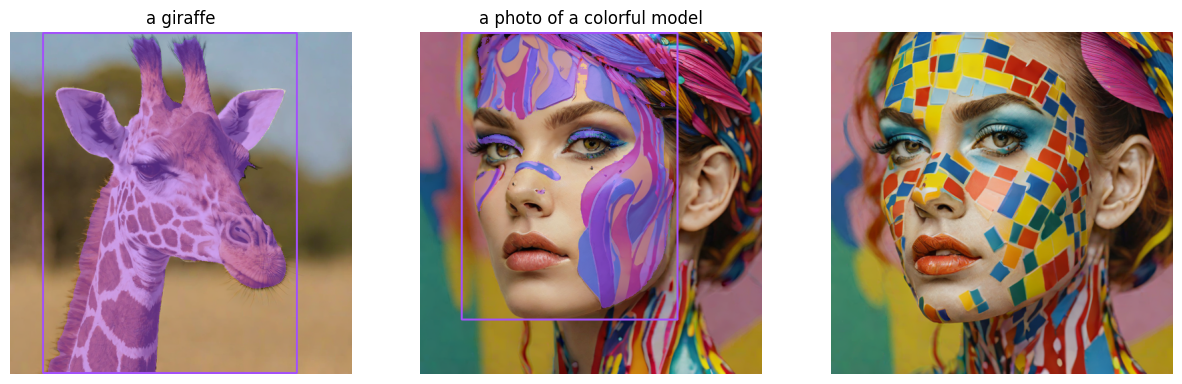

In [15]:
main("a giraffe", "a photo of a colorful model", "giraffe", "face", 
        blocks_to_intervene=["up.0.1"], combine_blocks=True, subtract_target_add_source=False,
        maintain_spatial_info=False,
        n_steps=4, m1=1., k_transfer=20000, stat="quantile", mode="neurons", 
        result_name=None)

In [10]:
import os
import json 
from collections import defaultdict
with open("./generated_piebench.json", "r") as f:
    pb = json.load(f)

pb[0]
blocks_to_intervene = []
if use_down:
     blocks_to_intervene.append("down.2.1")
if use_up:
     blocks_to_intervene.append("up.0.1")
if use_up0:
     blocks_to_intervene.append("up.0.0")
if use_mid:
     blocks_to_intervene.append("mid.0")


expid2name= {"0":"random", # -> remove
"1":"change object", # default
"2":"add object", # done 
"3":"delete object", # done 
"4":"change content", # possible -> (this should apply to all edits i guess as long as the two versions of the image are similar to each other)take edit mask in original, boost editing mask and surpress orignal mask
"5":"change pose", # somewhat possible -> switch
"6":"change color", # done
"7":"change material",# done 
"8":"change background", # done
"9":"change style" # done }
}

def remove_brakets(txt):
     return txt.replace("[","").replace("]","")

cnt = defaultdict(int)
mode = "steering"
m1 = 2.
maintain_spatial_info = True
prefix = os.path.join(prefix, "steering")
for d in pb:
     try:
          if d["editing_type_id"] in [] or cnt[d["editing_type_id"]] > 10:
               continue
          key = d["id"]
          print(key)
          path = os.path.join(prefix, f"down{use_down}_up{use_up}_up0{use_up0}_mid{use_mid}_T{n_steps}_ktrans{k_transfer}_str{m1}/{d['editing_type_id']}")
          original_prompt = remove_brakets(d["original_prompt"])
          editing_prompt = remove_brakets(d["editing_prompt"])
          os.makedirs(path, exist_ok=True)
          if d["editing_type_id"] in ['0']:
               continue
          elif d["editing_type_id"] in ['2']: # add object
               main(editing_prompt, original_prompt, d["edit_target"], d["edit_source"], 
                    use_source_mask_in_both = True, subtract_target_add_source=True,
                    maintain_spatial_info=maintain_spatial_info,
                    blocks_to_intervene=blocks_to_intervene, combine_blocks=True,
                    n_steps=n_steps, m1=m1, k_transfer=k_transfer, stat="quantile", k=10, mode=mode, 
                    result_name=f"{path}/{key}")
          elif d["editing_type_id"] in ['3']: # delete object
               main(original_prompt, original_prompt, "~"+d["edit_source"], d["edit_source"], 
                    blocks_to_intervene=blocks_to_intervene, combine_blocks=True, subtract_target_add_source=False,
                    maintain_spatial_info=maintain_spatial_info,
                    n_steps=n_steps, m1=m1, k_transfer=k_transfer, stat="quantile", k=10, mode=mode, 
                    result_name=f"{path}/{key}")
          elif d["editing_type_id"] in ['4', '5'] + ['1', '6', '7', '8', '9']:
               main(editing_prompt, original_prompt, d["edit_target"], d["edit_source"], 
                    blocks_to_intervene=blocks_to_intervene, combine_blocks=True, subtract_target_add_source=True,
                    maintain_spatial_info=maintain_spatial_info,
                    n_steps=n_steps, m1=m1, k_transfer=k_transfer, stat="quantile", k=10, mode=mode, 
                    result_name=f"{path}/{key}")
          else:
               main(editing_prompt, original_prompt, d["edit_target"], d["edit_source"], 
                    blocks_to_intervene=blocks_to_intervene, combine_blocks=True, maintain_spatial_info=False,
                    n_steps=n_steps, m1=m1, k_transfer=k_transfer, stat="quantile", k=10, mode=mode, 
                    result_name=f"{path}/{key}")
          cnt[d["editing_type_id"]] += 1
     except Exception as e:
          print(e)
          continue
          

000000000000
000000000001
000000000002
000000000003
000000000004
000000000005
000000000006
000000000007
000000000008
000000000009
000000000010
000000000011
000000000012
000000000013
000000000014
000000000015
000000000016
000000000017
000000000018
000000000019
000000000020
000000000021
000000000022
000000000023
000000000024
000000000025
000000000026
000000000027
000000000028
000000000029
000000000030
000000000031
000000000032
000000000033
000000000034
000000000035
000000000036
000000000037
000000000038
000000000039
000000000040
000000000041
000000000042
000000000043
000000000044
000000000045
000000000046
000000000047
000000000048
000000000049
000000000050
000000000051
000000000052
000000000053
000000000054
000000000055
000000000056
000000000057
000000000058
000000000059
000000000060
000000000061
000000000062
000000000063
000000000064
000000000065
000000000066
000000000067
000000000068
000000000069
000000000070
000000000071
000000000072
000000000073
000000000074
000000000075
000000000076

KeyboardInterrupt: 

In [ ]:
main("a giraffe", "a photo of a colorful model", "giraffe", "face", 
        blocks_to_intervene=["up.0.1"], combine_blocks=True, subtract_target_add_source=True,
        maintain_spatial_info=False,
        n_steps=4, m1=2., k_transfer=k_transfer, stat="quantile", k=10, mode="adding", 
        result_name=None)